In [6]:
# for correct relative imports
import sys; sys.path.append("../")

In [7]:
import warnings
warnings.filterwarnings("ignore")

import torch
from torch.utils.data import DataLoader, TensorDataset

from diffusers import DDPMScheduler
import pandas as pd
import numpy as np
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import pprint

from sklearn.preprocessing import StandardScaler

from var_es_dgm import TimeGrad
from var_es_dgm.basic_models import HistoricalSimulation, VarCov
from var_es_dgm.stat_tests import generate_report
from var_es_dgm.utils import seed_everything, compute_individual_returns, compute_portfolio_returns, \
    estimate_var_es_torch, pick_device

In [3]:
sns.set_style("darkgrid", {"axes.facecolor": ".9"})
sns.set_context("paper")

In [4]:
DATA_FOLDER = "../../data/"
df = pd.read_csv(DATA_FOLDER + "complete_stocks.csv")
df["Date"] = pd.to_datetime(df["Date"])

In [5]:
len(df["Ticker"].unique())

89

In [6]:
res_var_5 = list()
res_hist_5 = list()
res_varcov_5 = list()

In [7]:
RANDOM_STATE = 12

In [8]:
seed_everything(RANDOM_STATE + 0)
n_stocks = 10
tickers = np.random.choice(df["Ticker"].unique(), n_stocks, replace=False)
weights = 1/n_stocks
print("Portfolio = {0}".format(" + ".join([f"{weights} * {i}"for i in tickers])))
df_copy = df.loc[df["Ticker"].isin(tickers)].copy(deep=True)

df_returns = compute_individual_returns(df_copy)
df_returns = compute_portfolio_returns(df_returns)

univariate_target = df_returns["Return_Target"]

univariate_target = univariate_target.values[1:]
train_size = df_returns[df_returns.Date <= "2022-06-01"].index[-1] + 1
test_size = len(univariate_target) - train_size
train = univariate_target[:train_size]

ss = StandardScaler()
train_scaled = torch.tensor(ss.fit_transform(train.reshape(-1, 1)), dtype=torch.float32)

seed_everything(RANDOM_STATE)
context_size = 90
num_train_samples = 3000
train_data = torch.zeros(num_train_samples, context_size, train_scaled.shape[1])
train_target = torch.zeros(num_train_samples, 1, train_scaled.shape[1])
train_idx = np.random.choice(np.arange(context_size, train_scaled.shape[0]), num_train_samples, replace=False)

for i in tqdm(range(num_train_samples)):
    idx = train_idx[i]
    train_context = train_scaled[idx-context_size:idx]
    target_obs = train_scaled[idx]
    train_data[i] = train_context
    train_target[i] = target_obs

# Create DataLoader for ease of torch training
train_loader = DataLoader(TensorDataset(train_data, train_target), batch_size=128, shuffle=False)


temp = torch.tensor(ss.transform(univariate_target.reshape(-1, 1)))
test_data_context = torch.zeros(test_size, context_size, temp.shape[1])
test_data_real = torch.zeros(test_size, 1, temp.shape[1])
for i in range(test_size):
    idx = i + train_size
    test_data_context[i] = temp[idx-context_size:idx]
    test_data_real[i] = temp[idx]

seed_everything(RANDOM_STATE)
sheduler = DDPMScheduler(num_train_timesteps=46, beta_end=0.35878774019831244, clip_sample=False)
model = TimeGrad(1, 1, hidden_size=50, num_layers=2, scheduler=sheduler, num_inference_steps=46)

# sheduler = DDPMScheduler(num_train_timesteps=27, beta_end=0.022640643857559373, clip_sample=False)
# model = TimeGrad(1, 1, hidden_size=50, num_layers=2, scheduler=sheduler, num_inference_steps=27)
# n_epochs = 5


optimizer = torch.optim.Adam(model.parameters(), lr=0.0008985916117829954)
device = pick_device()
n_epochs = 31
model.to(device)

model.fit(train_loader, optimizer, n_epochs, str(device))

Portfolio = 0.1 * INTC + 0.1 * DHR + 0.1 * COP + 0.1 * MRK + 0.1 * HON + 0.1 * T + 0.1 * MSFT + 0.1 * AXP + 0.1 * PEP + 0.1 * SYK


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

Epochs:   0%|          | 0/31 [00:00<?, ?it/s]

[0.9473990698655447,
 0.6241990414758524,
 0.3764382352431615,
 0.35714906516174477,
 0.3248212231944005,
 0.31675764359533787,
 0.29758432259162265,
 0.31724051634470624,
 0.2771225596467654,
 0.2811320448915164,
 0.2517309036726753,
 0.24946614851554236,
 0.29376580007374287,
 0.26689336635172367,
 0.2869152221828699,
 0.2821197584271431,
 0.2689396968732278,
 0.2686588143308957,
 0.2886557796349128,
 0.26942983580132324,
 0.2889765724539757,
 0.25965792251129943,
 0.26455564610660076,
 0.2748835353801648,
 0.2654894416530927,
 0.26461944232384366,
 0.24918552860617638,
 0.26559922595818836,
 0.2549177904923757,
 0.2501844571282466,
 0.26570004659394425]

In [61]:
i = 0

In [62]:
seed_everything(RANDOM_STATE)
alpha=0.05
n_samples=500
device="mps"
test_obs = test_data_context[[i]]

model.eval()
model.to(device)
batch = 500
arr = torch.zeros((n_samples // batch) * batch)

with torch.no_grad():
    for i in range(0, n_samples // batch):
        x = torch.cat([test_obs for _ in range(batch)])
        arr[i * batch : (i + 1) * batch] = (
            model.forward(x.to(device)).flatten().detach().cpu()
        )
arr = arr.reshape(-1, 1)
est = HistoricalSimulation(alpha=alpha)

VaR_5_TimeGrad, ES_5_TimeGrad = est.predict(arr)

In [63]:
VaR_5_TimeGrad = ss.inverse_transform([[VaR_5_TimeGrad]]).item()
ES_5_TimeGrad = ss.inverse_transform([[ES_5_TimeGrad]]).item()
real = ss.inverse_transform([[test_data_real[i].item()]]).item()

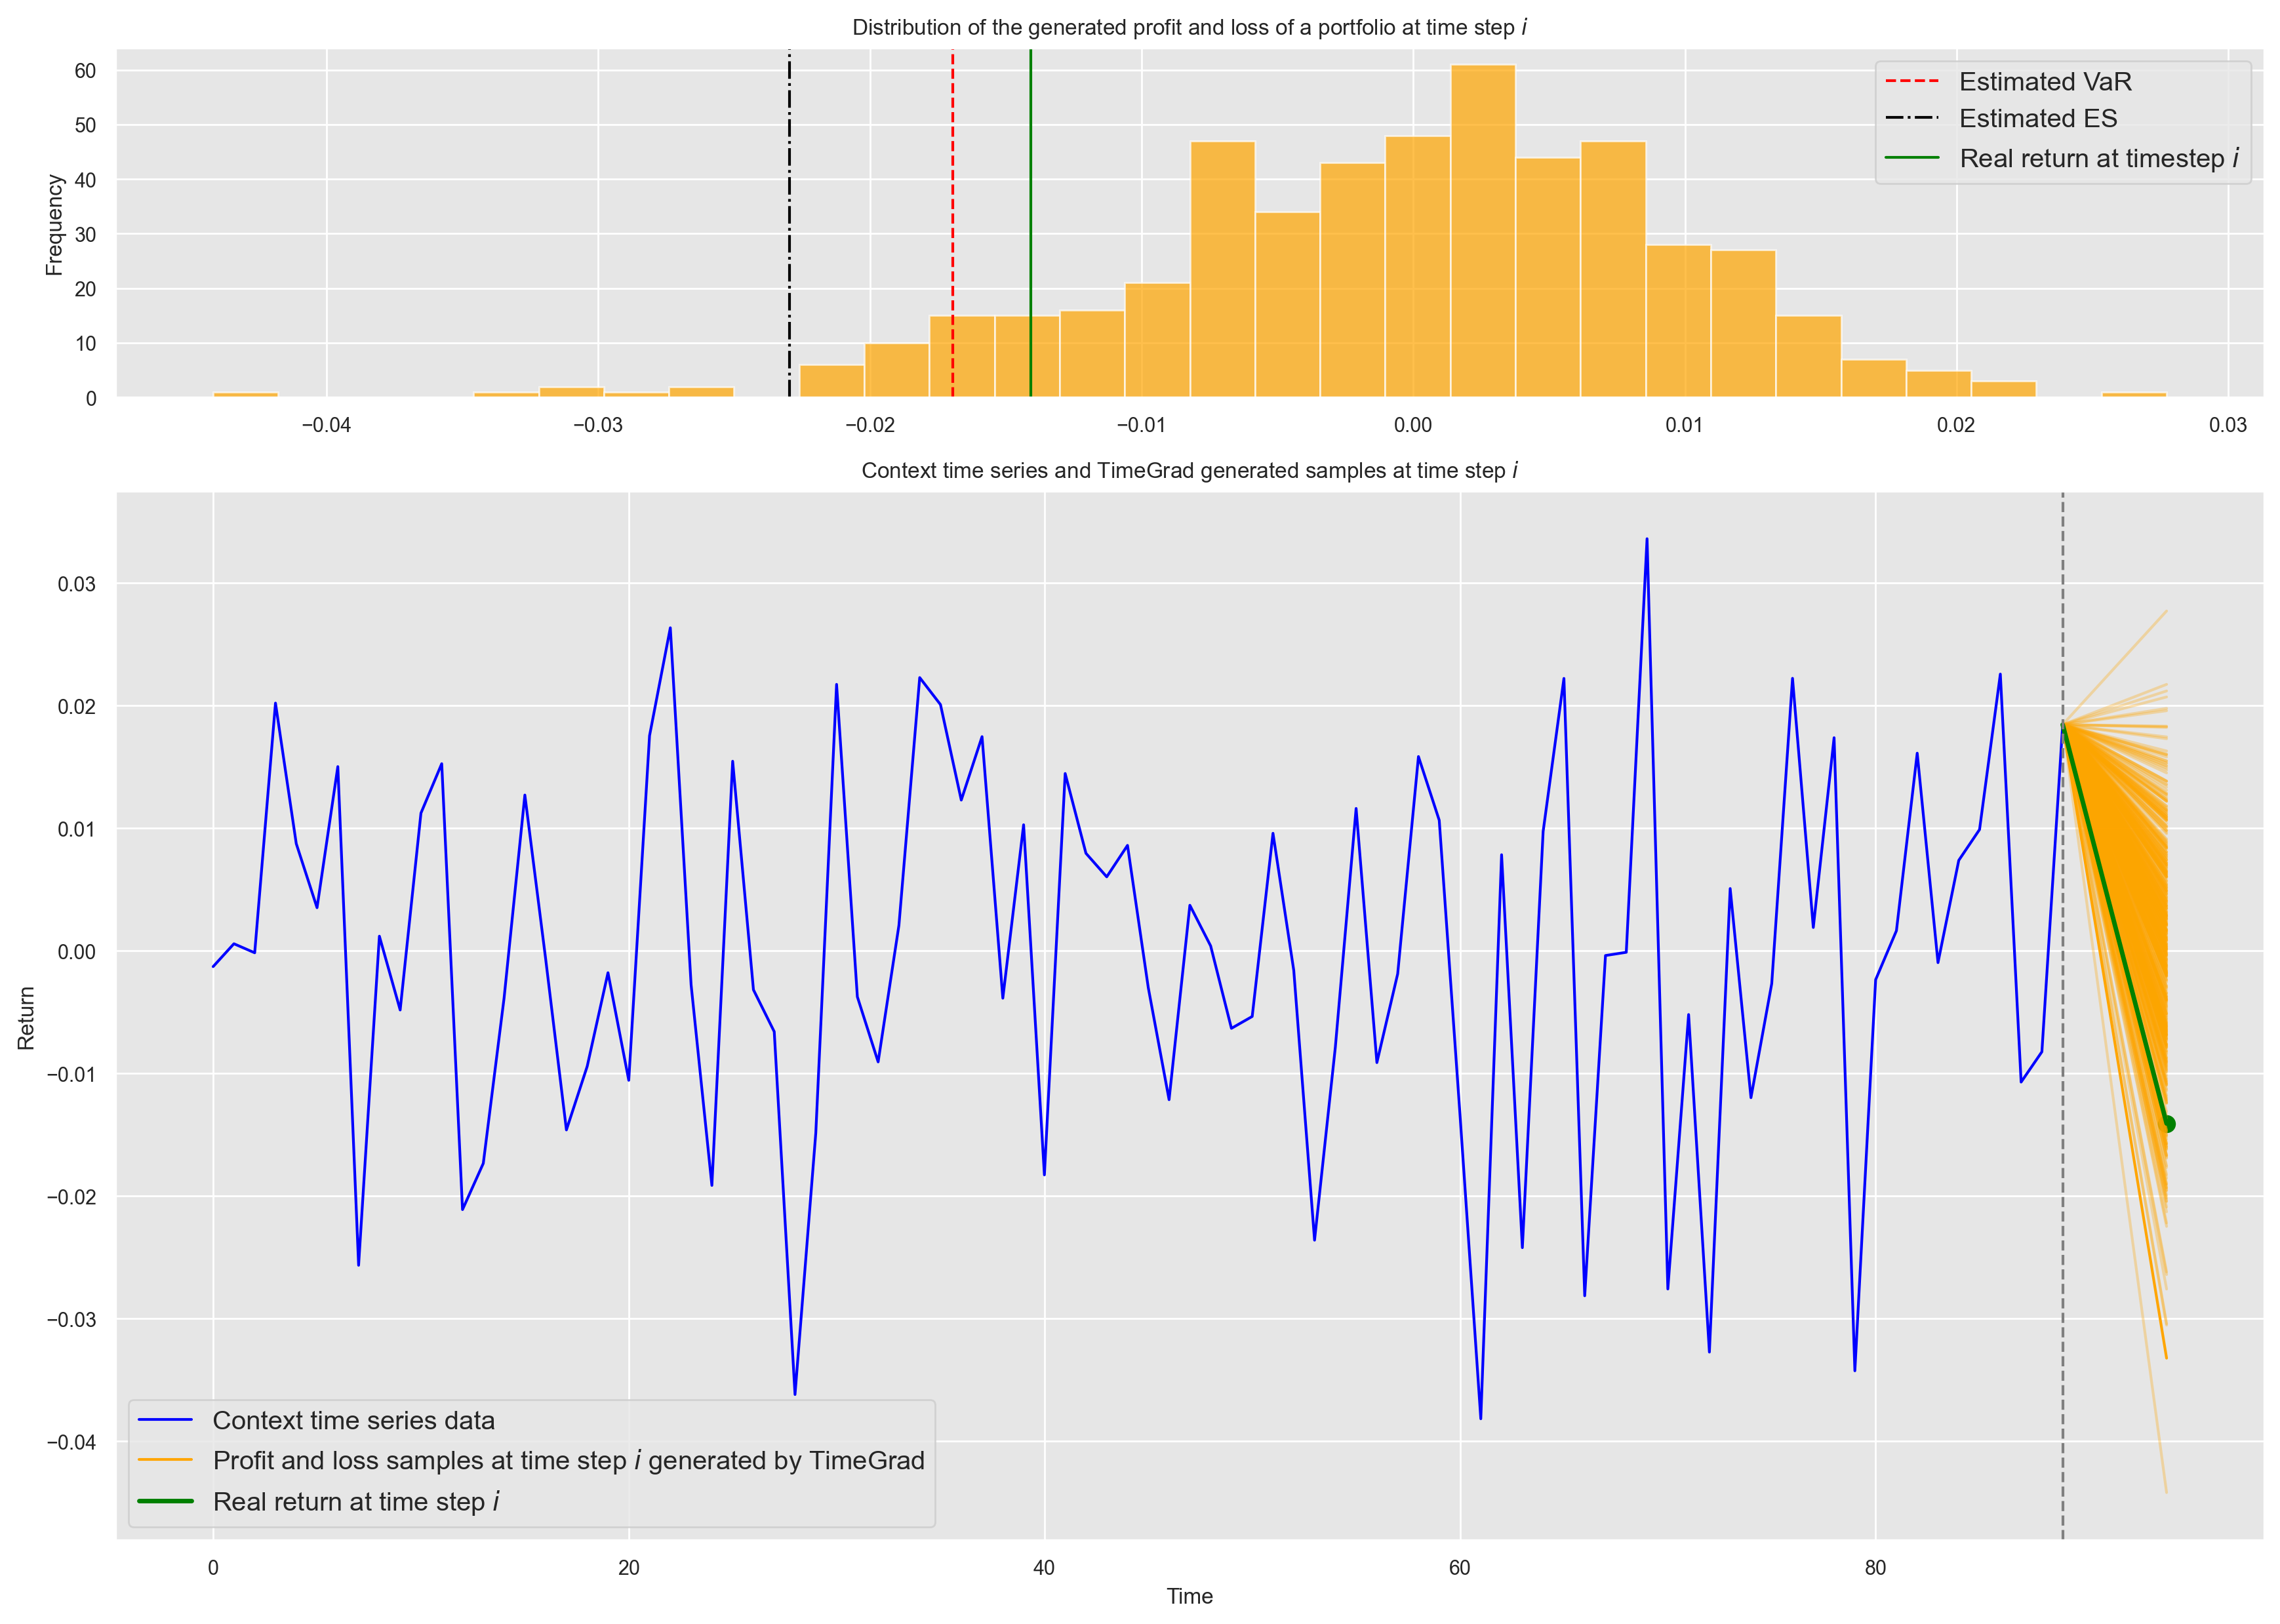

In [69]:
future_predictions = ss.inverse_transform(arr)
#future_predictions = future_predictions[future_predictions > -1.4].reshape(-1, 1)
future_steps = 5
time_series = ss.inverse_transform(test_obs.reshape(-1, 1)).flatten()
n_points = time_series.shape[0]
n_future_paths = future_predictions.shape[0]

# Create a figure with two subplots (one for the histogram and one for the time series)
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 10), gridspec_kw={'height_ratios': [1, 3]}, dpi=250)

# Plot the histogram of the first step of future predictions on the top subplot
future_first_step = future_predictions[:, 0]
ax1.hist(future_first_step, bins=30, color="orange", alpha=0.7)
ax1.axvline(VaR_5_TimeGrad, linestyle="--", label="Estimated VaR", color="red")
ax1.axvline(ES_5_TimeGrad, linestyle="-.", label="Estimated ES", color="black")
ax1.axvline(real, label="Real return at timestep $i$", color="green")
ax1.set_title('Distribution of the generated profit and loss of a portfolio at time step $i$')
ax1.set_ylabel('Frequency')
ax1.legend(fontsize='large')

# Plot the historical time series on the bottom subplot
ax2.plot(range(n_points), time_series, label='Context time series data', color='blue')

# Plot multiple one-step-ahead prediction paths on the bottom subplot
last_time_point = n_points - 1
for i in range(n_future_paths - 1):
    ax2.plot([last_time_point, last_time_point + future_steps], [time_series[-1], future_predictions[i, :].item()], color="orange", alpha=0.3)
ax2.plot([last_time_point, last_time_point + future_steps], [time_series[-1], future_predictions[-1, :].item()], color="orange", alpha=1, label="Profit and loss samples at time step $i$ generated by TimeGrad")


# Plot real obs
ax2.plot([last_time_point, last_time_point + future_steps], [time_series[-1], real], color="green", alpha=1, linewidth=2, label="Real return at time step $i$")
ax2.scatter(last_time_point + future_steps, real, color="green", s=50)

# Mark the last observation in the time series on the bottom subplot
ax2.axvline(x=last_time_point, color='grey', linestyle='--')
# ax2.scatter(last_time_point, time_series[-1], color='red')  # Mark the final point

# Adding labels and title to the bottom subplot
ax2.set_xlabel('Time')
ax2.set_ylabel('Return')
ax2.set_title("Context time series and TimeGrad generated samples at time step $i$")
ax2.legend(fontsize='large')

# Adjust layout to ensure titles and labels don't overlap
plt.tight_layout()

# Show the plot
plt.show()

fig.savefig("../../paper/graphics/proposed_approach.png")
